# DICE 2016R

This notebook compares DICE.jl to the `DICE2016R-091916ap.gms` GAMS file.

The results herein have been obtained via [this repository](https://github.com/cmkellett/DICE2013R-mc/), although it is not a thorough comparison it's the best we have for now.

If you have a GAMS license, please take a look at [this issue](https://github.com/Libbum/DICE.jl/issues/3).

In [1]:
# For Solving #
using DICE;

# For Plotting #
using Plots;

# For Comparing with GAMS data
using DataFrames;
using CSV;

## Base Price Scenario

The 2016R beta version has a base carbon price and an optimal carbon price scenario.

If you are interested in just the preset scenarios there is no reason to generate a configuration struct by calling `options(v2016R())`, since this is called internally and altered as needed if necessary.

Calling the solve function directly is all that's needed to obtain all results.

In [2]:
base = solve(BasePrice, v2016R())

Total number of variables............................:     2701
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      300
                     variables with only upper bounds:      100
Total number of equality constraints.................:     2412
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       99


Number of Iterations....: 98

                                   (scaled)                 (unscaled)
Objective...............:  -4.5226463459866773e+03   -4.5226463459866773e+03
Dual infeasibility......:   1.1368683772161603e-13    1.1368683772161603e-13
Constraint violation....:   4.5519298330631841e-09    4.5519298330631841e-09
Complementarity.........:   2.5059035981901827e-09    2.5059035981901827e-09
Overall NLP e

Base (current policy) carbon price scenario using v2016R beta.
Maximization problem with:
 * 1312 linear constraints
 * 400 quadratic constraints
 * 799 nonlinear constraints
 * 2701 variables
Solver is Ipopt

The variable `base` is now a complete solution of type `DICENarrative`.

It contains all of the model parameters and information, as well as usable results.

In [3]:
fieldnames(base)

8-element Array{Symbol,1}:
 :constants 
 :parameters
 :model     
 :scenario  
 :version   
 :variables 
 :equations 
 :results   

Whilst the `results` are fairly comprehensive, you may wish to look at specific values of the model directly. Since most of these are in their raw state you will need to `import JuMP` to read them correctly.

---

Word of warning: if you `print(base.model)` in this notebook you're gonna have a bad time.
It's apparently too big to print or something.
The thread just locks up/spools forever.

There's a *limit output* notebook extension which can truncate things for you.
It seems to be necessary if you want to use notebooks which have actual output.

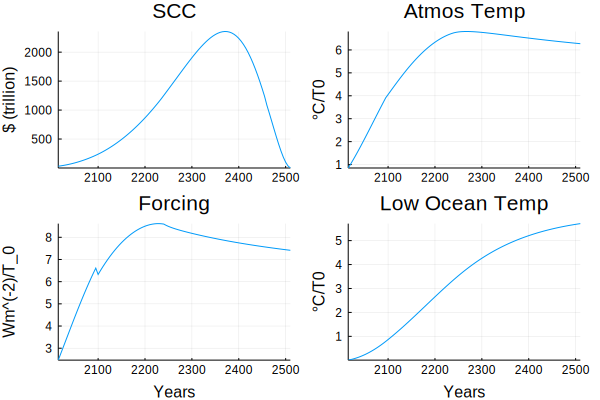

In [4]:
# Plot major outputs #
r = base.results;
a = plot(r.years,r.scc, ylabel="\$ (trillion)", title="SCC")
b = plot(r.years,r.Tₐₜ, ylabel="°C/T0", title="Atmos Temp")
c = plot(r.years,r.FORC, xlabel="Years", ylabel="Wm^(-2)/T_0", title="Forcing")
d = plot(r.years,r.Tₗₒ, xlabel="Years", ylabel="°C/T0", title="Low Ocean Temp")
plot(a,b,c,d,layout=(2,2),legend=false)

# Optimal Scenario

The optimal carbon price scenario is ran in a similar fashion.

In [5]:
opt = solve(OptimalPrice, v2016R())

Total number of variables............................:     2701
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      300
                     variables with only upper bounds:      100
Total number of equality constraints.................:     2412
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       99


Number of Iterations....: 95

                                   (scaled)                 (unscaled)
Objective...............:  -4.5222571835202561e+03   -4.5222571835202561e+03
Dual infeasibility......:   1.1368683772161603e-13    1.1368683772161603e-13
Constraint violation....:   4.5849749552573371e-09    4.5849749552573371e-09
Complementarity.........:   2.5059036111646657e-09    2.5059036111646657e-09
Overall NLP e

Optimal carbon price scenario using v2016R beta.
Maximization problem with:
 * 1312 linear constraints
 * 400 quadratic constraints
 * 799 nonlinear constraints
 * 2701 variables
Solver is Ipopt

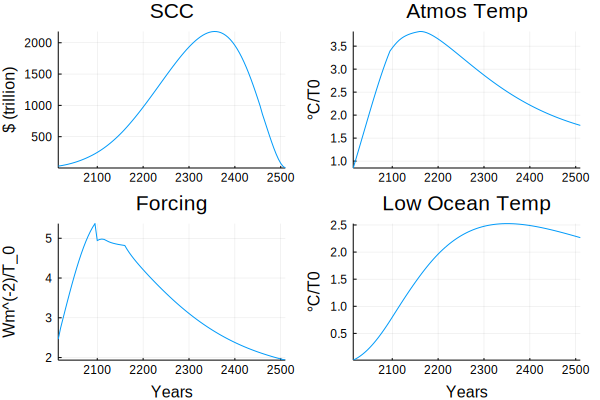

In [6]:
# Plot major outputs #
ro = opt.results;
a = plot(ro.years,ro.scc, ylabel="\$ (trillion)", title="SCC")
b = plot(ro.years,ro.Tₐₜ, ylabel="°C/T0", title="Atmos Temp")
c = plot(ro.years,ro.FORC, xlabel="Years", ylabel="Wm^(-2)/T_0", title="Forcing")
d = plot(ro.years,ro.Tₗₒ, xlabel="Years", ylabel="°C/T0", title="Low Ocean Temp")
plot(a,b,c,d,layout=(2,2),legend=false)

## Comparision

The forcing values are incorrect in the comparison file.

In the GAMS source,

```gams
forcoth(t) = fex0+ (1/17)*(fex1-fex0)*(t.val-1)$(t.val lt 18)+ (fex1-fex0)$(t.val ge 18)
```

`fex0` is `0.5` and `fex1` is `1.0`. Thus we expect the else to output `0.5` continually.
The comparison run must have the else portion set to `1.0` as we see a 1:1 comparison in all tested values apart from small deviations in `S` when that is the case.

One possible alternative may have been to set `fex0 = 0.0`, but this gives an incorrect initial condition&mdash;see the cells below which validate this.

Feel free to check these results yourself if you have a GAMS license and CONOPT.

In [7]:
#Load in the results of an 'optimal=true' gams run.
gams = CSV.read("2016RResults.csv", transpose=true);

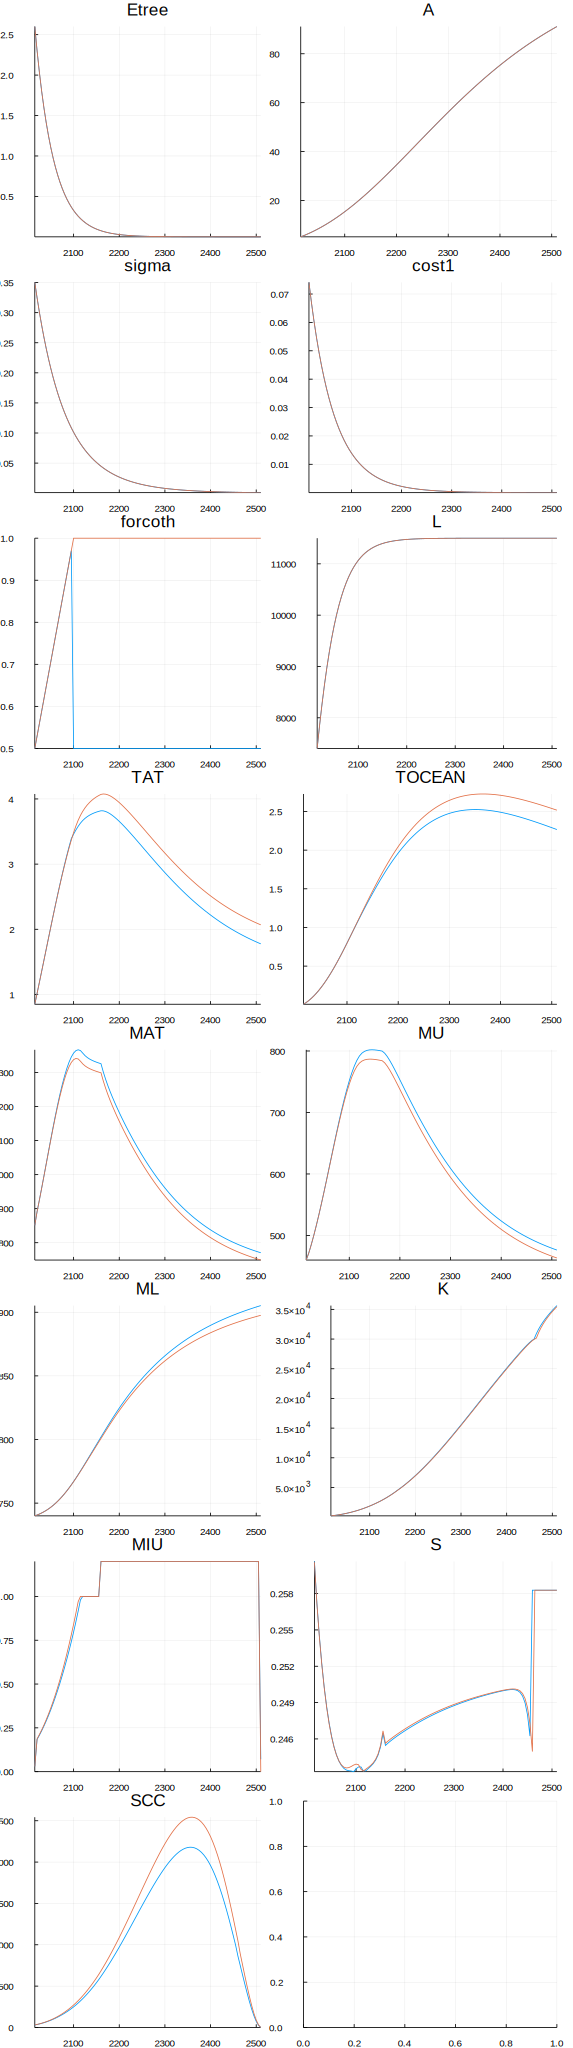

In [8]:
a = plot(ro.years,opt.parameters.Etree, title="Etree")
plot!(ro.years,gams[1])
b = plot(ro.years,opt.parameters.A, title="A")
plot!(ro.years,gams[2])
c = plot(ro.years,opt.parameters.σ, title="sigma")
plot!(ro.years,gams[3])
d = plot(ro.years,opt.parameters.θ₁, title="cost1")
plot!(ro.years,gams[4])
e = plot(ro.years,opt.parameters.fₑₓ, title="forcoth") #PROBLEM
plot!(ro.years,gams[5])
f = plot(ro.years,opt.parameters.L, title="L")
plot!(ro.years,gams[6])
g = plot(ro.years,ro.Tₐₜ, title="TAT")
plot!(ro.years,gams[7])
h = plot(ro.years,ro.Tₗₒ, title="TOCEAN")
plot!(ro.years,gams[8])
i = plot(ro.years,ro.Mₐₜ, title="MAT")
plot!(ro.years,gams[9])
j = plot(ro.years,ro.Mᵤₚ, title="MU")
plot!(ro.years,gams[10])
k = plot(ro.years,ro.Mₗₒ, title="ML")
plot!(ro.years,gams[11])
l = plot(ro.years,ro.K, title="K")
plot!(ro.years,gams[12])
m = plot(ro.years,ro.μ, title="MIU")
plot!(ro.years,gams[13])
n = plot(ro.years,ro.S, title="S")
plot!(ro.years,gams[14])
o = plot(ro.years,ro.scc, title="SCC")
plot!(ro.years,gams[15])
p = plot([],[])
plot(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,layout=(8,2),legend=false,label=["Julia" "GAMS"],size=(700,2500))

In [9]:
conf = options(v2016R(), fₑₓ0 = 0.0);
test0 = solve(OptimalPrice, v2016R(), config = conf)

Total number of variables............................:     2701
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      300
                     variables with only upper bounds:      100
Total number of equality constraints.................:     2412
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       99


Number of Iterations....: 95

                                   (scaled)                 (unscaled)
Objective...............:  -4.5240008958173257e+03   -4.5240008958173257e+03
Dual infeasibility......:   1.1368683772161603e-13    1.1368683772161603e-13
Constraint violation....:   5.2097633984615754e-09    5.2097633984615754e-09
Complementarity.........:   2.5059036026854403e-09    2.5059036026854403e-09
Overall NLP e

Optimal carbon price scenario using v2016R beta.
Maximization problem with:
 * 1312 linear constraints
 * 400 quadratic constraints
 * 799 nonlinear constraints
 * 2701 variables
Solver is Ipopt

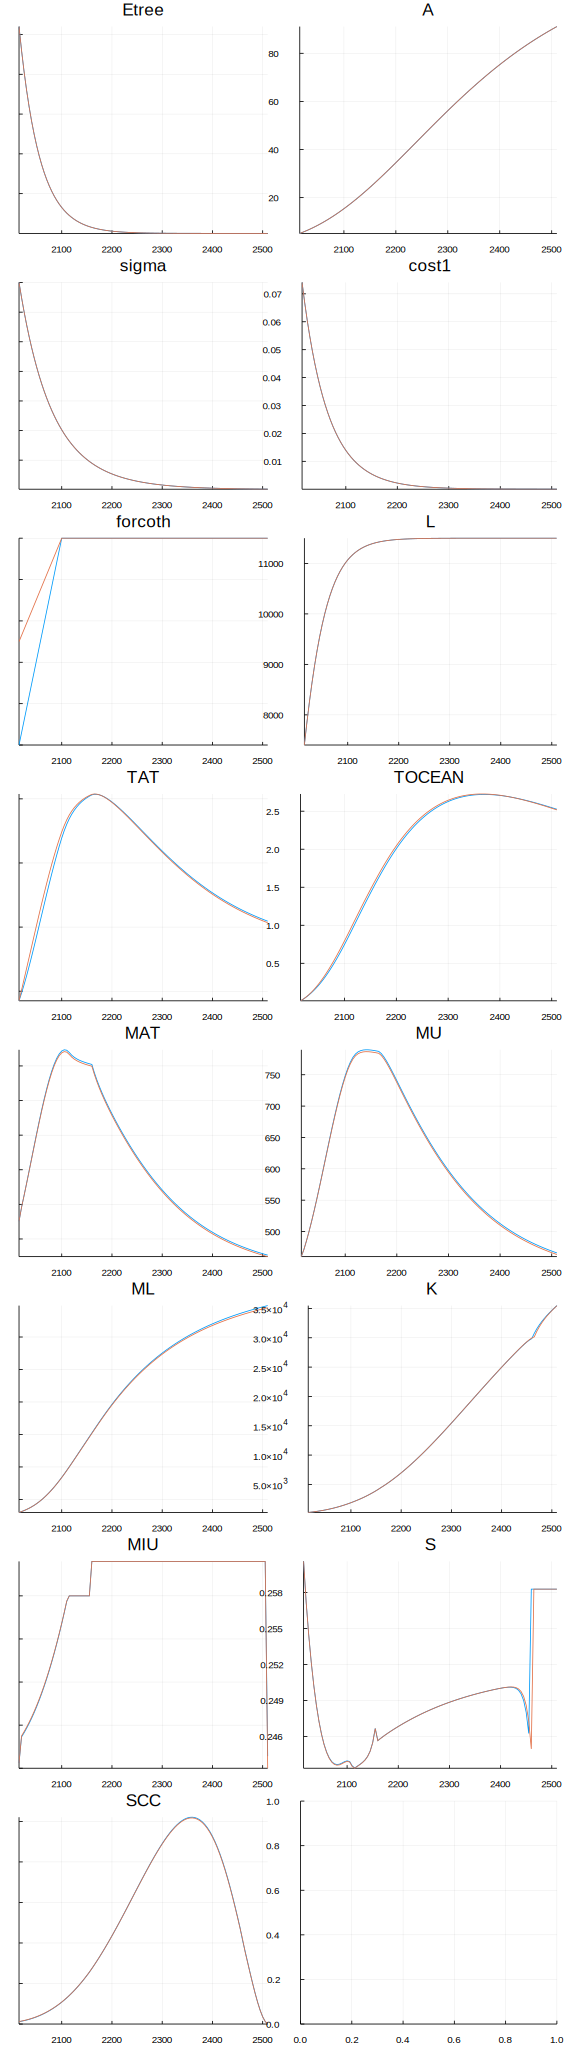

In [10]:
r0 = test0.results;
a = plot(r0.years,test0.parameters.Etree, title="Etree")
plot!(r0.years,gams[1])
b = plot(r0.years,test0.parameters.A, title="A")
plot!(r0.years,gams[2])
c = plot(r0.years,test0.parameters.σ, title="sigma")
plot!(r0.years,gams[3])
d = plot(r0.years,test0.parameters.θ₁, title="cost1")
plot!(r0.years,gams[4])
e = plot(r0.years,test0.parameters.fₑₓ, title="forcoth")
plot!(r0.years,gams[5])
f = plot(r0.years,test0.parameters.L, title="L")
plot!(r0.years,gams[6])
g = plot(r0.years,r0.Tₐₜ, title="TAT")
plot!(r0.years,gams[7])
h = plot(r0.years,r0.Tₗₒ, title="TOCEAN")
plot!(r0.years,gams[8])
i = plot(r0.years,r0.Mₐₜ, title="MAT")
plot!(r0.years,gams[9])
j = plot(r0.years,r0.Mᵤₚ, title="MU")
plot!(r0.years,gams[10])
k = plot(r0.years,r0.Mₗₒ, title="ML")
plot!(r0.years,gams[11])
l = plot(r0.years,r0.K, title="K")
plot!(r0.years,gams[12])
m = plot(r0.years,r0.μ, title="MIU")
plot!(r0.years,gams[13])
n = plot(r0.years,r0.S, title="S")
plot!(r0.years,gams[14])
o = plot(r0.years,r0.scc, title="SCC")
plot!(r0.years,gams[15])
p = plot([],[])
plot(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,layout=(8,2),legend=false,label=["Julia" "GAMS"],size=(700,2500))